# Introduction to RCPSP

What is RCPSP ? (Resource Constrained Project Scheduling Problem)

- $M$ activities or tasks in a project (instance)
- Precedence constraints: 

    > If activity $j\in[1,M]$ is a successor of activity $i\in[1,M]$, then activity $i$ must be completed before activity $j$ can be started

- Resource constraints: 

    > Each project is assigned a set of K renewable resources where each resource $k$ is available in $R_{k}$ units for the entire duration of the project. Each activity may require one or more of these resources to be completed. While scheduling the activities, the daily resource usage for resource $k$ can not exceed $R_{k}$ units. 
    
- Each activity $j$ takes $d_{j}$ time units to complete.

- The overall goal of the problem is usually to minimize the makespan.

Here we focus on *single mode RCPSP with renewable resources*, but there exists also variants of the problem
- multi-mode: a task can be performed in several ways (modes), with specific duration and resources needs. The choice of the mode is in this case part of the solution.
- mix of renewable and non-renewable resources.


## Prerequisites


Concerning the python kernel to use for this notebook:
- If running locally, be sure to use an environment with discrete-optimization.
- If running on colab, the next cell does it for you.
- If running on binder, the environment should be ready.


In [1]:
# On Colab: install the library
on_colab = "google.colab" in str(get_ipython())
if on_colab:
    import sys  # noqa: avoid having this import removed by pycln

    !{sys.executable} -m pip install -U pip

    # uninstall google protobuf conflicting with ray and sb3
    ! pip uninstall -y protobuf

    # install dev version for dev doc, or release version for release doc
    !{sys.executable} -m pip install git+https://github.com/airbus/discrete-optimization@master#egg=discrete-optimization

### Imports

In [2]:
import logging
import random

import matplotlib.pyplot as plt
import nest_asyncio
import networkx as nx
import numpy as np

from discrete_optimization.datasets import fetch_data_from_psplib
from discrete_optimization.rcpsp.parser import get_data_available, parse_file

# Main module for RCPSP Model
from discrete_optimization.rcpsp.solution import RcpspSolution
from discrete_optimization.rcpsp.utils import (
    Graph,
    compute_graph_rcpsp,
    plot_ressource_view,
    plot_task_gantt,
)

# patch asyncio so that applications using async functions can run in jupyter
nest_asyncio.apply()

# set logging level
logging.basicConfig(level=logging.INFO)

### Download datasets

If not yet available, we import the datasets from [psplib](https://www.om-db.wi.tum.de/psplib/data.html).

In [3]:
needed_datasets = ["j301_1.sm"]
download_needed = False
try:
    files_available_paths = get_data_available()
    for dataset in needed_datasets:
        if len([f for f in files_available_paths if dataset in f]) == 0:
            download_needed = True
            break
except:
    download_needed = True

if download_needed:
    fetch_data_from_psplib()

### Set random seed (for reproducible results in this notebook)

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)


set_random_seed()

## View input data

We use here the instance of an RCPSP described in the file `j301_1.sm`.

### File structure
Let us have a look of that file.

In [5]:
filepath = [f for f in get_data_available() if "j301_1.sm" in f][0]
with open(filepath, "rt") as f:
    print(f.read())

************************************************************************
file with basedata            : j30_17.bas
initial value random generator: 28123
************************************************************************
projects                      :  1
jobs (incl. supersource/sink ):  32
horizon                       :  158
RESOURCES
  - renewable                 :  4   R
  - nonrenewable              :  0   N
  - doubly constrained        :  0   D
************************************************************************
PROJECT INFORMATION:
pronr.  #jobs rel.date duedate tardcost  MPM-Time
    1     30      0       38       26       38
************************************************************************
PRECEDENCE RELATIONS:
jobnr.    #modes  #successors   successors
   1        1          3           2   3   4
   2        1          3           6  11  15
   3        1          3           7   8  13
   4        1          3           5   9  10
   5        1          1     

There are 32 jobs, including the source task (1) and the sink task (32). 

- The first part of the file describe the precedence constraints : 
  > Task $1$ should finish before task $2$, $3$, $4$ start.
  
- The second part of the file details the duration and resource usage per task : 
  > Task $3$ lasts 4 units of times and requires 10 units of $R_1$
  

### Parsing file
We parse the file to get a RCPSP model object in discrete-optimization library.

In [6]:
filepath = [f for f in get_data_available() if "j301_1.sm" in f][0]
rcpsp_problem = parse_file(filepath)
print(type(rcpsp_problem))
print(rcpsp_problem)
print("Nb jobs : ", rcpsp_problem.n_jobs)
print("Precedences : ", rcpsp_problem.successors)
print("Resources Availability : ", rcpsp_problem.resources)

<class 'discrete_optimization.rcpsp.problem.RcpspProblem'>
I'm a RCPSP problem with 32 tasks.. and ressources =['R1', 'R2', 'R3', 'R4']
Nb jobs :  32
Precedences :  {1: [2, 3, 4], 2: [6, 11, 15], 3: [7, 8, 13], 4: [5, 9, 10], 5: [20], 6: [30], 7: [27], 8: [12, 19, 27], 9: [14], 10: [16, 25], 11: [20, 26], 12: [14], 13: [17, 18], 14: [17], 15: [25], 16: [21, 22], 17: [22], 18: [20, 22], 19: [24, 29], 20: [23, 25], 21: [28], 22: [23], 23: [24], 24: [30], 25: [30], 26: [31], 27: [28], 28: [31], 29: [32], 30: [32], 31: [32], 32: []}
Resources Availability :  {'R1': 12, 'R2': 13, 'R3': 4, 'R4': 12}


### Precedence graph
We can have a visual version of the precedence graph :

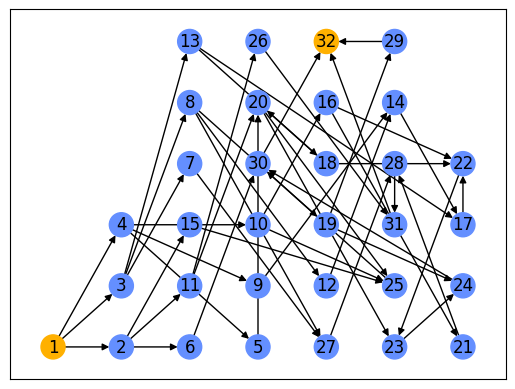

In [7]:
# compute graph
graph: Graph = compute_graph_rcpsp(rcpsp_problem)
graph_nx = graph.to_networkx()
# compute positions
dfs = nx.dfs_tree(G=graph_nx, source=1, depth_limit=10)
shortest_path_length = nx.shortest_path_length(dfs, 1)
length_to_nodes = {}
position = {}
for node in sorted(shortest_path_length, key=lambda x: shortest_path_length[x]):
    length = shortest_path_length[node]
    while not (length not in length_to_nodes or len(length_to_nodes[length]) <= 5):
        length += 1
    if length not in length_to_nodes:
        length_to_nodes[length] = []
    length_to_nodes[length] += [node]
    position[node] = (length, len(length_to_nodes[length]))

# different color for source and sink task
sink_source_color = "#FFB000"
normal_task_color = "#648FFF"
node_color = len(graph_nx) * [normal_task_color]
node_color[0] = sink_source_color
node_color[-1] = sink_source_color

# plot
nx.draw_networkx(graph_nx, pos=position, node_color=node_color)
plt.show()

### Critical path 
We can compute the largest path possible from source to sink task, which gives a lower bound on the makespan. This method is usually called critical path. 
When we computed the graph in previous cell, each edges store the minimum duration of a task, we also store the opposite of this number in ```minus_min_duration``` attribute of an edge.

In [8]:
print(graph.edges[5])

(2, 15, {'1': 8, 'min_duration': 8, 'max_duration': 8, 'minus_min_duration': -8, 'minus_max_duration': -8, 'link': 1})


This means to fulfill the (2, 15) precedence you have to accomplish the task 2, which takes minimum 8 unit times to do. Let's compute the critical path. 

In [9]:
path = nx.astar_path(
    G=graph_nx,
    source=1,
    target=rcpsp_problem.n_jobs,
    heuristic=lambda x, y: -100 if x != rcpsp_problem.n_jobs else 0,
    weight="minus_min_duration",
)
edges = [(n1, n2) for n1, n2 in zip(path[:-1], path[1:])]
duration = sum(graph_nx[n[0]][n[1]]["min_duration"] for n in edges)
print("Duration of critical path : ", duration)

Duration of critical path :  38


We know that our makespan will be at minimum 38 then because we necessarly have to accomplish the task found in the critical path sequentially, and the sum of their duration is 38. We can visualize this path in the precedence graph : 

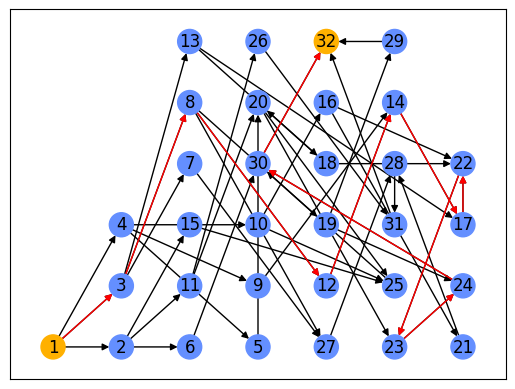

In [10]:
fig, ax = plt.subplots(1)
nx.draw_networkx(graph_nx, pos=position, node_color=node_color, ax=ax)
nx.draw_networkx_edges(graph_nx, pos=position, edgelist=edges, edge_color="r", ax=ax)
plt.show()

## Other procedure to compute critical path or minimum project duration

The critical path can be computed by a graph procedure described in https://www.youtube.com/watch?v=4oDLMs11Exs. It is a quite simple : forward and backward graph exploration. In the end it provides earliest start date, earliest finish date, and their counterpart (for a optimal schedule ignoring the resource requirements) : latest start date, latest finish date.

In [11]:
from discrete_optimization.rcpsp.solvers.cpm import CpmRcpspSolver

solver = CpmRcpspSolver(problem=rcpsp_problem)
critical_path = solver.run_classic_cpm()
edges = [(pi, pi1) for pi, pi1 in zip(critical_path[:-1], critical_path[1:])]
print(solver.map_node[rcpsp_problem.sink_task])

{'_ESD': 38, '_EFD': 38, '_LSD': 38, '_LFD': 38}


The critical path can be identified as nodes where all the values are equals.

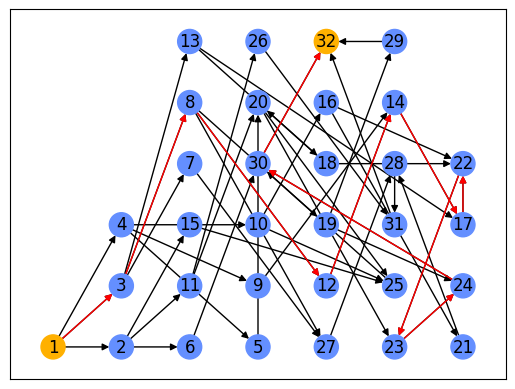

In [12]:
fig, ax = plt.subplots(1)
nx.draw_networkx(graph_nx, pos=position, node_color=node_color, ax=ax)
nx.draw_networkx_edges(graph_nx, pos=position, edgelist=edges, edge_color="r", ax=ax)
plt.show()

We find the same result as previously.
The CPM object is giving us more information on the problem than the pure longest path computation, let's look : 

In [13]:
for task in rcpsp_problem.tasks_list:
    print(f"CPM output for task {task} : {solver.map_node[task]}")

CPM output for task 1 : {'_ESD': 0, '_EFD': 0, '_LSD': 0, '_LFD': 0}
CPM output for task 2 : {'_ESD': 0, '_EFD': 8, '_LSD': 7, '_LFD': 15}
CPM output for task 3 : {'_ESD': 0, '_EFD': 4, '_LSD': 0, '_LFD': 4}
CPM output for task 4 : {'_ESD': 0, '_EFD': 6, '_LSD': 1, '_LFD': 7}
CPM output for task 5 : {'_ESD': 6, '_EFD': 9, '_LSD': 21, '_LFD': 24}
CPM output for task 6 : {'_ESD': 8, '_EFD': 16, '_LSD': 28, '_LFD': 36}
CPM output for task 7 : {'_ESD': 4, '_EFD': 9, '_LSD': 20, '_LFD': 25}
CPM output for task 8 : {'_ESD': 4, '_EFD': 13, '_LSD': 4, '_LFD': 13}
CPM output for task 9 : {'_ESD': 6, '_EFD': 8, '_LSD': 13, '_LFD': 15}
CPM output for task 10 : {'_ESD': 6, '_EFD': 13, '_LSD': 7, '_LFD': 14}
CPM output for task 11 : {'_ESD': 8, '_EFD': 17, '_LSD': 15, '_LFD': 24}
CPM output for task 12 : {'_ESD': 13, '_EFD': 15, '_LSD': 13, '_LFD': 15}
CPM output for task 13 : {'_ESD': 4, '_EFD': 10, '_LSD': 12, '_LFD': 18}
CPM output for task 14 : {'_ESD': 15, '_EFD': 18, '_LSD': 15, '_LFD': 18}
C

We access to all the labels that the critical path forward and backward pass computed. 

## Compute a "Dummy" solution for RCPSP
A solution can be defined as a permutation of jobs which is then transformed into a feasible schedule if possible using the SGS routine, which stands for serial schedule generation scheme. It consists at scheduling an activity as soon as it is available following the permutation order if possible.
The following algorithm is the following.

![image](../img/sgs.png)

### Compute a schedule from a given jobs permutation

In [14]:
permutation = list(range(rcpsp_problem.n_jobs_non_dummy))
# We just pick a random permutation of [0, n]
random.shuffle(permutation)
print(f"priority list given to sgs : {permutation}")
mode_list = [1 for i in range(rcpsp_problem.n_jobs)]
rcpsp_sol = RcpspSolution(
    problem=rcpsp_problem, rcpsp_permutation=permutation, rcpsp_modes=mode_list
)
print("schedule feasible: ", rcpsp_sol.rcpsp_schedule_feasible)
print("schedule: ", rcpsp_sol.rcpsp_schedule)
print("rcpsp_modes:", rcpsp_sol.rcpsp_modes)
fitnesses = rcpsp_problem.evaluate(rcpsp_sol)
print("fitnesses: ", fitnesses)
resource_consumption = rcpsp_problem.compute_resource_consumption(rcpsp_sol)
print("resource_consumption: ", resource_consumption)
print("mean_resource_reserve:", rcpsp_sol.compute_mean_resource_reserve())

priority list given to sgs : [19, 14, 10, 26, 22, 6, 5, 12, 11, 15, 9, 25, 29, 21, 16, 27, 1, 13, 18, 2, 17, 28, 4, 24, 7, 8, 23, 0, 3, 20]
schedule feasible:  True
schedule:  {1: {'start_time': 0, 'end_time': 0}, 3: {'start_time': 0, 'end_time': 4}, 8: {'start_time': 4, 'end_time': 13}, 12: {'start_time': 13, 'end_time': 15}, 7: {'start_time': 4, 'end_time': 9}, 13: {'start_time': 4, 'end_time': 10}, 27: {'start_time': 13, 'end_time': 21}, 18: {'start_time': 21, 'end_time': 26}, 4: {'start_time': 0, 'end_time': 6}, 19: {'start_time': 13, 'end_time': 16}, 29: {'start_time': 16, 'end_time': 23}, 9: {'start_time': 9, 'end_time': 11}, 14: {'start_time': 23, 'end_time': 26}, 17: {'start_time': 26, 'end_time': 32}, 10: {'start_time': 6, 'end_time': 13}, 16: {'start_time': 13, 'end_time': 23}, 21: {'start_time': 32, 'end_time': 34}, 28: {'start_time': 34, 'end_time': 37}, 2: {'start_time': 10, 'end_time': 18}, 11: {'start_time': 18, 'end_time': 27}, 15: {'start_time': 18, 'end_time': 27}, 6:

### Plotting the solution

#### Resource consumption over time : 

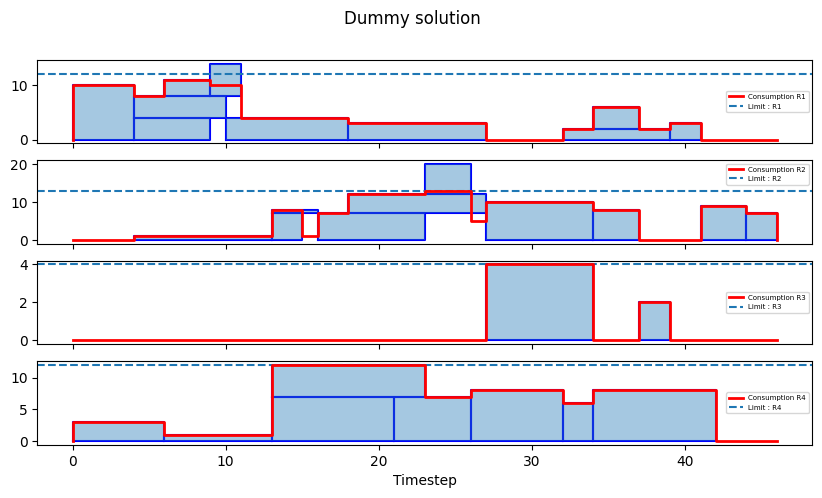

In [15]:
fig_resource_view = plot_ressource_view(
    rcpsp_problem=rcpsp_problem, rcpsp_sol=rcpsp_sol, title_figure="Dummy solution"
)

#### Task view
We can plot the schedule from a task point of view too, each line of the plot show where the task should be accomplished.

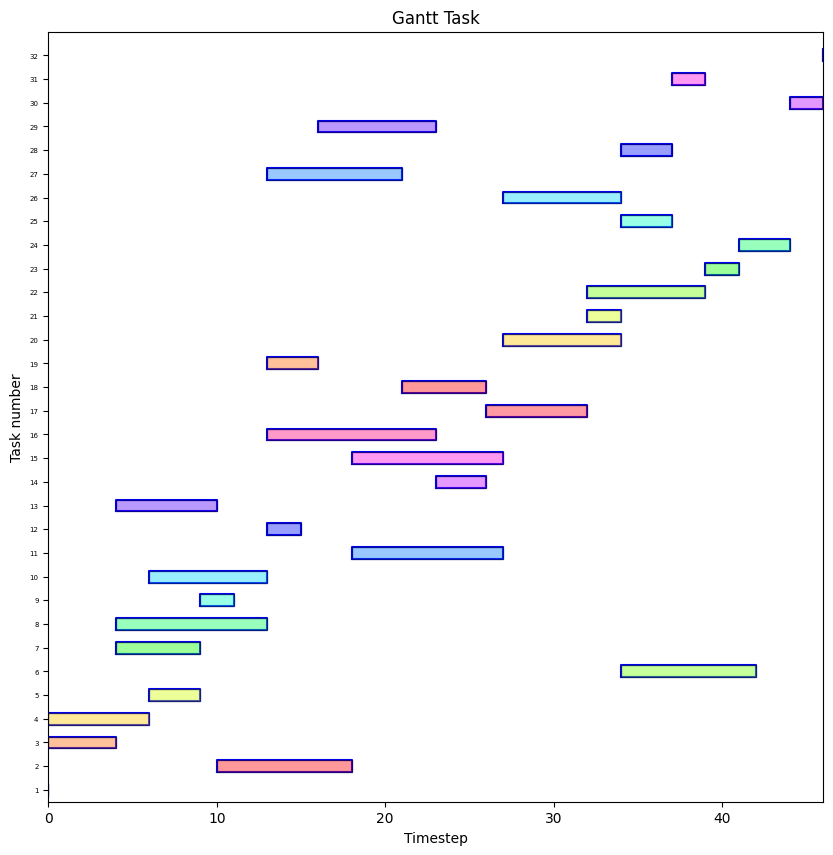

In [16]:
fig_gantt = plot_task_gantt(rcpsp_problem=rcpsp_problem, rcpsp_sol=rcpsp_sol)

## Conclusion

In this notebook you've been introduced to the definition of RCPSP problem which is a classical scheduling problem, with precedence constraint and resource consumption constraint.
We have illustrated the precedence graph and ways of computing longest path that gives us a lower bound of the total duration of the schedule.
Finally we introduced a method called *SGS* that computes a feasible schedule from a priority list of task to schedule.

In following notebooks, you'll be introduced to scheduling solvers providing good quality schedules with different paradigm : 
- [greedy heuristics](RCPSP%20%232%20Heuristics%20Solving.ipynb)
- [Metaheuristics and genetic algorithm](RCPSP%20%233%20Local%20search.ipynb)
- [Linear programming](RCPSP%20%234%20Linear%20programming.ipynb)
- [Constraint programming](RCPSP%20%235%20Constraint%20Programming.ipynb)
- [Large Neighborhood search](RCPSP%20%236%20Large%20Neighbourhood%20Search%20.ipynb)
